In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-15 18:19:27 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-15 18:19:27 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-15 18:19:27 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-15 18:19:30 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-15 18:19:30 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-15 18:19:30 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-15 18:19:30 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-15 18:19:31 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory


2025-09-15 18:19:31 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-09-15 18:19:31 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-09-15 18:19:31 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-15 18:19:31 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-15 18:20:22 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-15 18:20:22 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-15 18:20:22 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



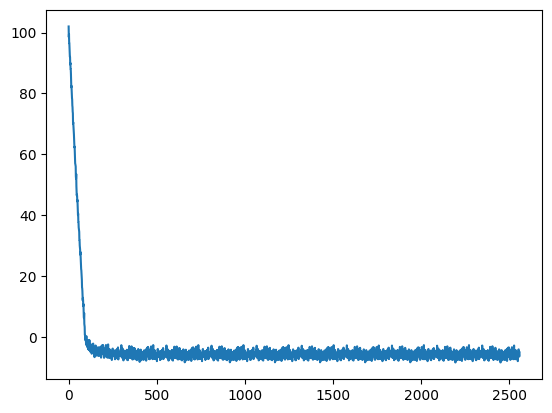

In [7]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     model_key.split("/")[-1],
#     # "distinct_options",
#     f"{select_task.task_name}",
#     "epoch_10.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz"
)



optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

79


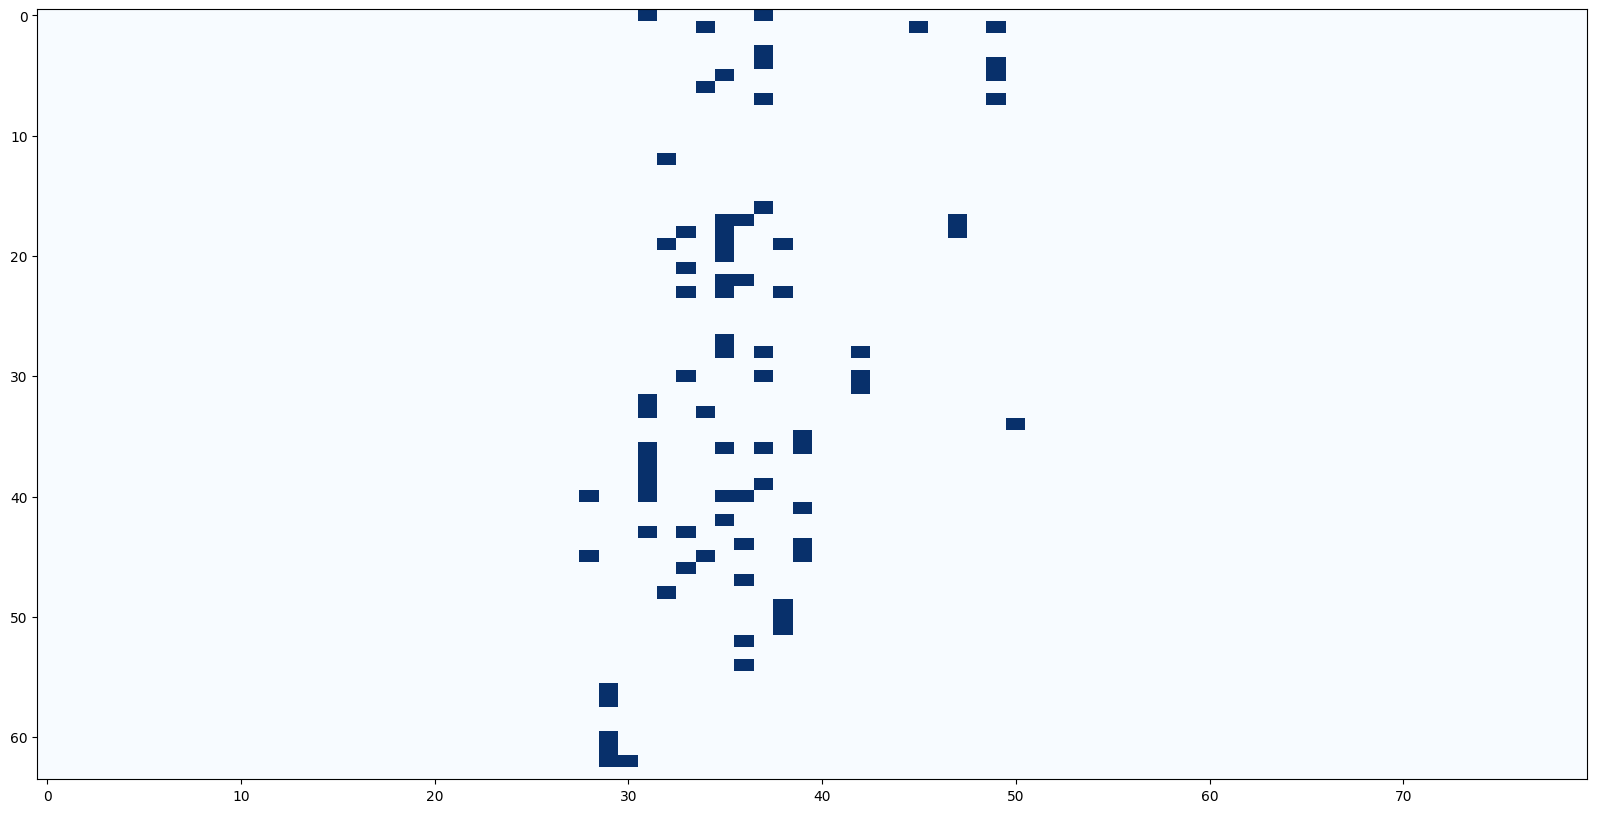

In [8]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected
]
print(len(heads_selected))

# HEADS = heads_selected

# (35, 19) in HEADS, (35, 19) in heads_selected

In [60]:
from src.selection.data import MCQify_sample

sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    # category="actor",
    # category="Brazil"
    category="vehicle",
    filter_by_lm_prediction=False,
)
sample = MCQify_sample(sample = sample, mt = mt)

print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')

a. Airplane
b. Cabinet
c. Lion
d. Headphones
e. Blender
f. Hickory
Which among these objects mentioned above is a vehicle?
Answer: >> " a"


In [61]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(),
    options=sample.options,
    mt=mt,
    heads=heads_selected,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-15 18:36:17 src.selection.functional DEBUG    Predictions: ['" a"[264] (p=0.594, logit=22.500)', '" Air"[6690] (p=0.117, logit=20.875)', '" ("[320] (p=0.117, logit=20.875)', '" An"[1556] (p=0.062, logit=20.250)', '" The"[578] (p=0.062, logit=20.250)']
2025-09-15 18:36:17 src.selection.functional INFO     Combined attention matrix for all heads


## Apply Logit Lens on the OV contribution

In [62]:
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
import copy
import baukit
from src.functional import patch_with_baukit, interpret_logits, get_hs
from src.selection.utils import get_first_token_id
from src.tokens import prepare_input

HEADS = copy.deepcopy(heads_selected)
tokenized = prepare_input(prompts=sample.prompt(), tokenizer=mt.tokenizer)

mt.reset_forward()
mt.set_attn_implementation("sdpa")

layers_to_heads = {}
for layer_idx, head_idx in HEADS:
    if layer_idx not in layers_to_heads:
        layers_to_heads[layer_idx] = []
    layers_to_heads[layer_idx].append(head_idx)

head_contributions = {}
for layer_idx, head_indices in layers_to_heads.items():
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    head_contributions[layer_idx] = {}

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=head_indices,
            store_head_contributions=head_contributions[layer_idx],
        ),
        attn_block,
    )

logit_location = (mt.lm_head_name, -1)
logit = get_hs(
    mt=mt,
    input=tokenized,
    locations = logit_location,
    return_dict=False
)

mt.reset_forward()
mt.set_attn_implementation("eager")

pred = interpret_logits(
    logits=logit,
    tokenizer=mt.tokenizer,
)
pred

2025-09-15 18:36:27 src.hooking.llama_attention WARNING  model.layers.35.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=15.5, __attn_output.norm().item()=15.5
2025-09-15 18:36:27 src.hooking.llama_attention WARNING  model.layers.37.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=12.0, __attn_output.norm().item()=12.0


[PredictedToken(token=' a', prob=0.6015625, logit=22.5, token_id=264, metadata=None),
 PredictedToken(token=' Air', prob=0.1181640625, logit=20.875, token_id=6690, metadata=None),
 PredictedToken(token=' (', prob=0.1044921875, logit=20.75, token_id=320, metadata=None),
 PredictedToken(token=' An', prob=0.0634765625, logit=20.25, token_id=1556, metadata=None),
 PredictedToken(token=' The', prob=0.0634765625, logit=20.25, token_id=578, metadata=None)]

In [63]:
from src.functional import logit_lens
from src.selection.data import get_options_for_answer

# head_contrib = head_contributions[35][19][:, -1, :]
head_contrib = []
for layer_idx, head_idx in HEADS:
    head_contrib.append(
        head_contributions[layer_idx][head_idx][:, -1, :].squeeze().cuda()
    )

head_contrib = torch.stack(head_contrib).sum(dim=0)

logit_lens(
    mt=mt,
    h=head_contrib,
    interested_tokens=[
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(sample) + sample.options
    ],
)

# head_contrib.shape

([PredictedToken(token=' Cunning', prob=0.03369140625, logit=10.1875, token_id=68845, metadata=None),
  PredictedToken(token='ietf', prob=0.006256103515625, logit=8.5, token_id=75168, metadata=None),
  PredictedToken(token='.cgi', prob=0.006256103515625, logit=8.5, token_id=60114, metadata=None),
  PredictedToken(token=':.:', prob=0.0040283203125, logit=8.0625, token_id=111898, metadata=None),
  PredictedToken(token=' Mayo', prob=0.0040283203125, logit=8.0625, token_id=58157, metadata=None)],
 OrderedDict([(88668,
               (50600,
                PredictedToken(token=' Blender', prob=2.1904706954956055e-06, logit=0.54296875, token_id=88668, metadata=None))),
              (294,
               (58572,
                PredictedToken(token=' d', prob=1.6614794731140137e-06, logit=0.265625, token_id=294, metadata=None))),
              (11452,
               (62545,
                PredictedToken(token=' Head', prob=1.4454126358032227e-06, logit=0.130859375, token_id=11452, metadata=

In [64]:
from src.functional import free_gpu_cache
del head_contributions
del head_contrib
free_gpu_cache()

## Just apply Logit Lens on the Latents

In [65]:
hs = get_hs(
    mt=mt,
    input=tokenized,
    locations=[(layer_name, -1) for layer_name in mt.layer_names],
    return_dict=True,
)

interested_tokens = [
    get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
    for opt in get_options_for_answer(sample) + sample.options
]

for layer_idx in range(mt.n_layer):
    layer_name = mt.layer_name_format.format(layer_idx)
    h = hs[(layer_name, -1)]
    ll_pred, ll_track = logit_lens(mt=mt, h=h, interested_tokens=interested_tokens)
    print(
        f"{layer_name} | {[mt.tokenizer.decode(token_id) for token_id in ll_track.keys()]} | {[str(pred) for pred in ll_pred]}"
    )

model.layers.0 | [' d', ' Hick', ' Lion', ' f', ' c', ' Blender', ' b', ' Cabinet', ' Head', ' a', ' Air', ' e'] | ['"ogo"[24404] (p=0.002, logit=6.406)', '" NotImplemented"[22273] (p=0.002, logit=6.344)', '" Salv"[32066] (p=0.001, logit=6.062)', '" Oswald"[90450] (p=0.001, logit=6.000)', '"럴"[121408] (p=0.001, logit=5.938)']
model.layers.1 | [' d', ' Hick', ' b', ' Lion', ' c', ' Blender', ' f', ' Cabinet', ' Head', ' a', ' Air', ' e'] | ['"럴"[121408] (p=0.003, logit=6.781)', '"ogo"[24404] (p=0.003, logit=6.688)', '" Oswald"[90450] (p=0.002, logit=6.438)', '" rem"[1323] (p=0.002, logit=6.438)', '"abi"[26140] (p=0.002, logit=6.375)']
model.layers.2 | [' d', ' b', ' c', ' f', ' Blender', ' Lion', ' Hick', ' a', ' Head', ' Cabinet', ' e', ' Air'] | ['"abi"[26140] (p=0.007, logit=8.000)', '"uni"[16080] (p=0.006, logit=7.812)', '" bois"[66304] (p=0.005, logit=7.688)', '"ds"[5469] (p=0.004, logit=7.594)', '" Mig"[38651] (p=0.004, logit=7.500)']
model.layers.3 | [' c', ' d', ' b', ' f', ' Hi

In [38]:
list(ll_track.keys())

[23910, 432, 83499, 14588, 58600, 67629]